# Transformer and BERT

- Vaswani et al., [Attention is All you Need.](https://papers.nips.cc/paper/7181-attention-is-all-you-need) NIPS 2017: 5998-6008
- Devlin et al., [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding.](https://www.aclweb.org/anthology/N19-1423/) NAACL-HLT (1) 2019: 4171-4186

---

- [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)
- [The Illustrated BERT, ELMo ...](https://jalammar.github.io/illustrated-bert/)
- [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html)

---

In [128]:
from transformers import BertModel, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [129]:
token_ids = tokenizer.encode('The new Berlin airport (BER) will open soon.')
token_ids

[1996, 2047, 4068, 3199, 1006, 2022, 2099, 1007, 2097, 2330, 2574, 1012]

In [6]:
tokenizer.convert_ids_to_tokens(token_ids)

['the',
 'new',
 'berlin',
 'airport',
 '(',
 'be',
 '##r',
 ')',
 'will',
 'open',
 'soon',
 '.']

----

In [7]:
bert = BertModel.from_pretrained('bert-base-uncased')
bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [131]:
from sklearn.preprocessing import LabelEncoder
import utils

gnad_train, gnad_test = utils.load_gnad()
label_encoder = LabelEncoder()

# turn all the data into integer indices
y_train = label_encoder.fit_transform(gnad_train.category)

In [133]:
y_train

array([5, 3, 6, ..., 7, 1, 4])

----

In [134]:
from transformers import BertTokenizer

def doc2bert(doc, tokenizer):
    tokens = tokenizer.tokenize(doc)[:510]  # NOTE: that's 510 SUBword tokens, not 510 tokens from the original document
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    
    # pad everything to 512
    if len(token_ids) < 510:
        token_ids = token_ids + [0] * (510 - len(token_ids))
        
    return [tokenizer.cls_token_id] + token_ids + [tokenizer.sep_token_id]

In [135]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

token_ids = (doc2bert(x_, tokenizer) for x_ in gnad_train.text)

In [136]:
import torch
from torch.utils.data import TensorDataset, RandomSampler, DataLoader

X_train = torch.LongTensor(list(token_ids))
y_train = torch.LongTensor(y_train)

batch_size = 8
data_train = TensorDataset(X_train, y_train)
sampler = RandomSampler(data_train)
train_dataloader = DataLoader(data_train, sampler=sampler, batch_size=8)

In [137]:
X_train, y_train

(tensor([[  101, 10296,   118,  ...,     0,     0,   102],
         [  101,   112, 10915,  ...,   179, 19093,   102],
         [  101, 10445, 35350,  ...,   119, 38141,   102],
         ...,
         [  101, 10445, 15877,  ...,     0,     0,   102],
         [  101, 23244, 52332,  ..., 64826, 10726,   102],
         [  101, 10915, 10298,  ..., 12471, 42085,   102]]),
 tensor([5, 3, 6,  ..., 7, 1, 4]))

In [138]:
from transformers import BertForSequenceClassification

bert = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=len(torch.unique(y_train)))

100%|██████████| 714314041/714314041 [01:30<00:00, 7904448.45B/s] 


Let's have quick look at what the output from looks like

In [139]:
output, *_ = bert(X_train[:4])
output

tensor([[-0.0162,  0.0039,  0.1008,  0.0674, -0.0679, -0.0271,  0.0286,  0.2357,
         -0.1319],
        [ 0.1414,  0.0765,  0.1642,  0.3456, -0.2813,  0.0801, -0.2042,  0.1813,
         -0.0446],
        [ 0.1205,  0.0798,  0.1975,  0.2624, -0.2067,  0.0496, -0.1636,  0.1453,
         -0.0393],
        [ 0.1747,  0.0619,  0.1261,  0.2841, -0.3193,  0.0542, -0.2113,  0.2201,
         -0.0830]], grad_fn=<AddmmBackward>)

In [140]:
import torch.nn.functional as F

F.log_softmax(output, dim=1).exp()

tensor([[0.1065, 0.1086, 0.1197, 0.1157, 0.1011, 0.1053, 0.1113, 0.1370, 0.0948],
        [0.1196, 0.1121, 0.1224, 0.1467, 0.0784, 0.1125, 0.0847, 0.1245, 0.0993],
        [0.1180, 0.1133, 0.1274, 0.1360, 0.0851, 0.1099, 0.0888, 0.1210, 0.1006],
        [0.1257, 0.1123, 0.1197, 0.1402, 0.0767, 0.1114, 0.0854, 0.1315, 0.0971]],
       grad_fn=<ExpBackward>)

## What's going on here?

In [141]:
bert

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

---

In [143]:
from transformers import AdamW
from transformers.optimization import WarmupLinearSchedule

num_epochs = 5

# pass the parameters of the classifier head ONLY to the optimizer
params = [p for n, p in bert.named_parameters() if 'classifier.' in n]
optimizer = AdamW(params, lr=3e-5, correct_bias=False)

num_total_steps = num_epochs * (len(train_dataloader.sampler) // batch_size)
num_warmup_steps = int(num_total_steps * 0.15)
scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)

# Learning Rate Schedule
## Warmup Linear Schedule

/Users/mattilyra/.local/share/virtualenvs/pydatanyc_2019-b2AkOBOU/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


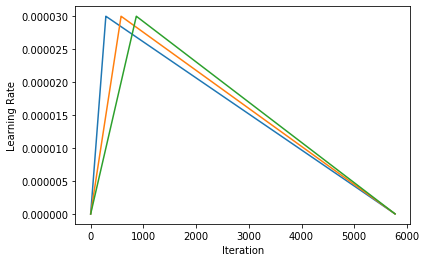

In [144]:
from matplotlib import pyplot as plt
%matplotlib inline

def plot_learning_rate(num_warmup_steps):
    scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)
    learning_rates = []
    for i in range(num_total_steps):
        learning_rates.append(scheduler.get_lr())
        scheduler.step()
    plt.plot(learning_rates);
    plt.xlabel('Iteration');
    plt.ylabel('Learning Rate');

plot_learning_rate(int(num_total_steps * 0.05))
plot_learning_rate(int(num_total_steps * 0.10))
plot_learning_rate(int(num_total_steps * 0.15))

In [145]:
import torch
torch.cuda.is_available()

False

# Document Classification with BERT

In [10]:
from tqdm import tqdm_notebook as tqdmn
from torch.nn.utils import clip_grad_norm_

# Use a GPU if one is available
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert.to(DEVICE)

for _ in tqdmn(range(num_epochs), total=num_epochs, desc="Epoch"):
    steps = tqdmn(train_dataloader,
                  total=X_train.size()[0] // train_dataloader.batch_size + 1,
                  desc='Mini-batch')
    train_loss = 0
    for i_step, batch in enumerate(steps):
        batch_X, batch_y = (b.to(DEVICE) for b in batch)
        loss, *_ = bert(batch_X, labels=batch_y)
        train_loss += loss.item()
        loss.backward()
        clip_grad_norm_(bert.parameters(), 1.0)
        steps.set_postfix_str(f'avg. loss {train_loss / (i_step + 1):.4f}')
        
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

In [15]:
bert.to('cpu')
torch.save(bert.to('cpu'), 'bert-20news-5epochs-HEAD.pt')

In [16]:
del batch_X, batch_y

In [17]:
torch.cuda.empty_cache()

---

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

X_test, y_test = zip(*[([tokenizer.cls_token_id] + tokenize(x, tokenizer) + [tokenizer.sep_token_id],
                         map_label(y_idx))
                        for x, y_idx in zip(data_test['data'], data_test['target'])])
label_map = {label: idx for idx, label in enumerate(set(y_test))}
y_test = [label_map[y_] for y_ in y_test]

In [19]:
from torch.utils.data import SequentialSampler
from torch.nn import functional as F

X_test = torch.LongTensor(X_test)

batch_size = 4
data_test = TensorDataset(X_test)
sampler = SequentialSampler(data_test)
test_dataloader = DataLoader(data_test, sampler=sampler, batch_size=batch_size)

bert.eval()
bert.to(DEVICE)
pred = []
for x, *_batch in test_dataloader:
    x = x.to(DEVICE)
    pred_, *_ = bert(x)
    _, pred_ = F.log_softmax(pred_, dim=1).exp().max(dim=1)
    pred.extend(pred_.cpu().numpy().tolist())

In [20]:
from sklearn import metrics

print(metrics.classification_report(y_test, pred, target_names=list(label_map.keys())))

              precision    recall  f1-score   support

         soc       0.00      0.00      0.00       398
         rec       0.00      0.00      0.00      1590
         alt       0.05      0.08      0.06       319
         sci       0.00      0.00      0.00      1579
        misc       0.00      0.00      0.00       390
        talk       0.30      0.18      0.22      1301
        comp       0.27      0.87      0.42      1955

    accuracy                           0.26      7532
   macro avg       0.09      0.16      0.10      7532
weighted avg       0.12      0.26      0.15      7532



/home/ubuntu/.local/share/virtualenvs/pydatanyc_2019-QOOn-cei/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                Linear SVM with parameter tuning

                  precision    recall  f1-score   support

            comp       0.84      0.87      0.86      1955
             soc       0.73      0.71      0.72       398
            talk       0.74      0.77      0.75      1301
             sci       0.78      0.73      0.76      1579
            misc       0.82      0.76      0.79       390
             rec       0.79      0.86      0.83      1590
             alt       0.62      0.41      0.49       319

        accuracy                           0.79      7532
       macro avg       0.76      0.73      0.74      7532
    weighted avg       0.79      0.79      0.79      7532
    
---

      BERT with fine-tuning the whole transformer stack

                  precision    recall  f1-score   support

             soc       0.55      0.70      0.61       398
             rec       0.82      0.69      0.75      1590
             alt       0.02      0.08      0.03       319
             sci       0.21      0.09      0.12      1579
            misc       0.81      0.55      0.65       390
            talk       0.63      0.58      0.60      1301
            comp       0.79      0.85      0.82      1955

        accuracy                           0.55      7532
       macro avg       0.54      0.51      0.51      7532
    weighted avg       0.60      0.55      0.57      7532


---

In [21]:
import torch
from torch.nn.utils import clip_grad_norm_

from transformers.optimization import WarmupLinearSchedule
from transformers import BertForSequenceClassification
from transformers import AdamW

from tqdm import tqdm_notebook as tqdmn

num_epochs = 5
bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(torch.unique(y_train)))
params = [p for n, p in bert.named_parameters()]  # if .classifier in n]
optimizer = AdamW(params, lr=3e-5, correct_bias=False)

num_total_steps = num_epochs * (len(train_dataloader.sampler)
                              // batch_size)
num_warmup_steps = int(num_total_steps * 0.15)
scheduler = WarmupLinearSchedule(optimizer,
                                 warmup_steps=num_warmup_steps,
                                 t_total=num_total_steps)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert.to(DEVICE)

for _ in tqdmn(range(num_epochs), total=num_epochs, desc="Epoch"):
    steps = tqdmn(train_dataloader,
                  total=X_train.size()[0] // train_dataloader.batch_size + 1,
                  desc='Mini-batch')
    train_loss = 0
    for i_step, batch in enumerate(steps):
        batch_X, batch_y = (b.to(DEVICE) for b in batch)
        loss, *_ = bert(batch_X, labels=batch_y)
        train_loss += loss.item()
        loss.backward()
        clip_grad_norm_(bert.parameters(), 1.0)
        steps.set_postfix_str(f'avg. loss {train_loss / (i_step + 1):.4f}')
        
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

In [22]:
bert.to('cpu')
torch.save(bert.to('cpu'), 'bert-20news-5epochs-ALL.pt')

In [23]:
torch.cuda.empty_cache()

In [24]:
from torch.utils.data import SequentialSampler
from torch.nn import functional as F

X_test = torch.LongTensor(X_test)

batch_size = 4
data_test = TensorDataset(X_test)
sampler = SequentialSampler(data_test)
test_dataloader = DataLoader(data_test, sampler=sampler, batch_size=batch_size)

bert.eval()
bert.to(DEVICE)
pred = []
for x, *_batch in test_dataloader:
    x = x.to(DEVICE)
    pred_, *_ = bert(x)
    _, pred_ = F.log_softmax(pred_, dim=1).exp().max(dim=1)
    pred.extend(pred_.cpu().numpy().tolist())

In [25]:
from sklearn import metrics

print(metrics.classification_report(y_test, pred, target_names=list(label_map.keys())))

              precision    recall  f1-score   support

         soc       0.55      0.70      0.61       398
         rec       0.82      0.69      0.75      1590
         alt       0.02      0.08      0.03       319
         sci       0.21      0.09      0.12      1579
        misc       0.81      0.55      0.65       390
        talk       0.63      0.58      0.60      1301
        comp       0.79      0.85      0.82      1955

    accuracy                           0.55      7532
   macro avg       0.54      0.51      0.51      7532
weighted avg       0.60      0.55      0.57      7532



----

In [121]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Mathieu Blondel <mathieu@mblondel.org>
# License: BSD 3 clause
from pprint import pprint
from time import time
import logging

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(tol=1e-3)),
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (20,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}

In [38]:
data = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

def map_label(label_idx):
    return data['target_names'][label_idx].split('.')[0]

y_names = list(map(map_label, data.target))
label_map = {label: idx for idx, label in enumerate(set(y_names))}
y = [label_map[y_] for y_ in y_names]

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=3, verbose=1)

grid_search.fit(data.data, y)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.5min
[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed:  4.4min finished


done in 1630.918s

Best score: 0.827
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 20
	clf__penalty: 'elasticnet'
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)


In [39]:
data_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
y_test = [label_map[map_label(y_)] for y_ in data_test.target]

In [19]:
from sklearn import metrics

In [41]:
print(metrics.classification_report(y_test,
                                    grid_search.best_estimator_.predict(data_test.data),
                                    target_names=list(label_map.keys())))

              precision    recall  f1-score   support

        comp       0.84      0.87      0.86      1955
         soc       0.73      0.71      0.72       398
        talk       0.74      0.77      0.75      1301
         sci       0.78      0.73      0.76      1579
        misc       0.82      0.76      0.79       390
         rec       0.79      0.86      0.83      1590
         alt       0.62      0.41      0.49       319

    accuracy                           0.79      7532
   macro avg       0.76      0.73      0.74      7532
weighted avg       0.79      0.79      0.79      7532



----

# German News Categorisation

In [114]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [115]:
from utils import load_gnad

gnad_train, gnad_test = load_gnad()

In [116]:
gnad_train.head()

,category,text
0,Sport,21-Jähriger fällt wohl bis Saisonende aus. Wie...
1,Kultur,"'Erfundene Bilder zu Filmen, die als verloren ..."
2,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...
3,Wirtschaft,"Putin: ""Einigung, dass wir Menge auf Niveau vo..."
4,Inland,Estland sieht den künftigen österreichischen P...


In [122]:
from sklearn.preprocessing import LabelEncoder

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=3, verbose=1)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(gnad_train.category)
grid_search.fit(gnad_train.text, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  3.9min
[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed: 12.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

Let's see if BERT can do better than that

In [124]:
from sklearn import metrics

y_test = label_encoder.transform(gnad_test.category)


print(metrics.classification_report(y_test,
                                    grid_search.best_estimator_.predict(gnad_test.text),
                                    target_names=label_encoder.classes_))

               precision    recall  f1-score   support

         Etat       0.94      0.76      0.84        67
       Inland       0.81      0.84      0.83       102
International       0.89      0.83      0.86       151
       Kultur       0.91      0.89      0.90        54
     Panorama       0.81      0.84      0.82       168
        Sport       0.99      0.98      0.99       120
          Web       0.92      0.91      0.91       168
   Wirtschaft       0.82      0.87      0.85       141
 Wissenschaft       0.87      0.96      0.92        57

     accuracy                           0.88      1028
    macro avg       0.88      0.88      0.88      1028
 weighted avg       0.88      0.88      0.88      1028



In [126]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

token_ids = (doc2bert(x_, tokenizer) for x_ in gnad_train.text)

In [127]:
import torch
from torch.utils.data import TensorDataset, RandomSampler, DataLoader

X_train = torch.LongTensor(list(token_ids))
y_train = torch.LongTensor(y)

batch_size = 8
data_train = TensorDataset(X_train, y_train)
sampler = RandomSampler(data_train)
train_dataloader = DataLoader(data_train, sampler=sampler, batch_size=8)

In [113]:
from transformers import AdamW, BertForSequenceClassification
from transformers.optimization import WarmupLinearSchedule

num_epochs = 5
bert = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=len(torch.unique(y_train)))
params = [p for n, p in bert.named_parameters()]
optimizer = AdamW(params, lr=3e-5, correct_bias=False)


num_total_steps = num_epochs * (len(train_dataloader.sampler) // batch_size)
num_warmup_steps = int(num_total_steps * 0.15)
scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)

In [10]:
from tqdm import tqdm_notebook as tqdmn
from torch.nn.utils import clip_grad_norm_

# Use a GPU if one is available
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert.to(DEVICE)

for _ in tqdmn(range(num_epochs), total=num_epochs, desc="Epoch"):
    steps = tqdmn(train_dataloader,
                  total=X_train.size()[0] // train_dataloader.batch_size + 1,
                  desc='Mini-batch')
    train_loss = 0
    for i_step, batch in enumerate(steps):
        batch_X, batch_y = (b.to(DEVICE) for b in batch)
        loss, *_ = bert(batch_X, labels=batch_y)
        train_loss += loss.item()
        loss.backward()
        clip_grad_norm_(bert.parameters(), 1.0)
        steps.set_postfix_str(f'avg. loss {train_loss / (i_step + 1):.4f}')
        
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()